https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment - выбранный датасет


In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('pollution_dataset.csv') # записываем данные в датафрейм

print(df.head()) # выведем первые строки датасета, чтобы убедиться, что все хорошо

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         27.2      51.7   35.1  46.2  26.7  32.2  0.98   
1         26.3      59.3    1.0   6.2  38.3  20.4  0.68   
2         27.9      73.2   20.0  39.4  19.6   5.8  0.95   
3         23.9      51.9   14.7  24.3   5.2  12.6  1.24   
4         25.2      59.0   26.3  30.9  26.8  13.5  1.06   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                           11.2                 314   Hazardous  
1                           13.5                 298        Good  
2                            5.4                 309        Good  
3                            4.5                 282        Poor  
4                            5.6                 293        Poor  


Уберем лишний столбец в датасете, чтобы оставить только числовые значения к рассмотрению


In [4]:
input_data = df.drop(df.columns[[-1]], axis=1)
print(input_data.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         27.2      51.7   35.1  46.2  26.7  32.2  0.98   
1         26.3      59.3    1.0   6.2  38.3  20.4  0.68   
2         27.9      73.2   20.0  39.4  19.6   5.8  0.95   
3         23.9      51.9   14.7  24.3   5.2  12.6  1.24   
4         25.2      59.0   26.3  30.9  26.8  13.5  1.06   

   Proximity_to_Industrial_Areas  Population_Density  
0                           11.2                 314  
1                           13.5                 298  
2                            5.4                 309  
3                            4.5                 282  
4                            5.6                 293  


In [5]:
# Сделаем бинарный столбец для того, чтобы понять баланс датасета. Используем столбец микродисперсных частиц, чтобы рассмотреть случаи, превышающие опасное содержание пыли в воздухе
input_data['Dangerous PM2.5'] = input_data['PM2.5'].apply(lambda x: 1 if x > 27.5 else 0)  

X = input_data.drop(columns = ['Dangerous PM2.5', 'PM2.5'])
y = input_data['Dangerous PM2.5']

# Разделим данные на тестовые и тренировочные.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

input_data['Dangerous PM2.5'].value_counts()

Dangerous PM2.5
0    3045
1    1955
Name: count, dtype: int64

Здесь видим, что наше распределение оказалось несбалансированным, разница между данными близка к 20 процентам.
Исправим баланс нашего атрибута

In [6]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

In [9]:
knn = KNeighborsClassifier(n_neighbors=2)
dec_tree = DecisionTreeClassifier(random_state=42)

knn.fit(X_train_smote, y_train_smote)
y_pred_knn = knn.predict(X_test)

dec_tree.fit(X_train_smote, y_train_smote)
y_pred_tree = dec_tree.predict(X_test)

print(classification_report(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       609
           1       0.90      0.68      0.78       391

    accuracy                           0.85      1000
   macro avg       0.86      0.82      0.83      1000
weighted avg       0.85      0.85      0.84      1000

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       609
           1       0.91      0.92      0.91       391

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



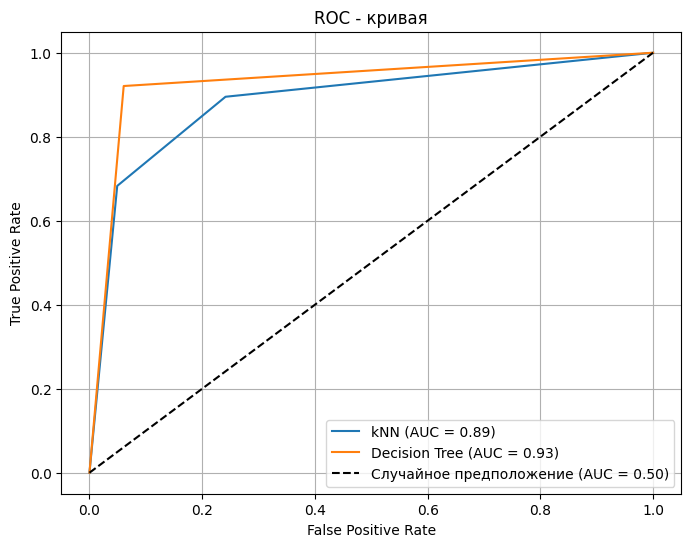

In [8]:
# Построим ROC-кривую.
from sklearn.metrics import roc_curve, auc

y_prob_knn = knn.predict_proba(X_test)[:, 1]
y_prob_tree = dec_tree.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_tree = auc(fpr_tree, tpr_tree)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f"kNN (AUC = {roc_auc_knn:.2f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Случайное предположение (AUC = 0.50)")
plt.title("ROC - кривая")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Вывод: 
1. Класс 'Опасный PM2.5' (0)

<table>
<thead>
<tr><th>Model        </th><th style="text-align: right;">  Precision</th><th style="text-align: right;">  Recall</th><th style="text-align: right;">  F-score</th></tr>
</thead>
<tbody>
<tr><td>kNN          </td><td style="text-align: right;">       0.82</td><td style="text-align: right;">    0.95</td><td style="text-align: right;">     0.88</td></tr>
<tr><td>Decision Tree</td><td style="text-align: right;">       0.95</td><td style="text-align: right;">    0.94</td><td style="text-align: right;">     0.94</td></tr>
</tbody>
</table>

Метрика Precision относительно нашего бинарного атрибута у kNN гораздо хуже, чем у дерева решений, так же несмотря на перевес в параметре recall, значение f-score у кNN гораздо ниже, что показывает меньший баланс при обработке нулевых данных нашего атрибута, чем при использовании дерева решений

2. Класс 'Опасный PM2.5' (1)

<table>
<thead>
<tr><th>Model        </th><th style="text-align: right;">  Precision</th><th style="text-align: right;">  Recall</th><th style="text-align: right;">  F-score</th></tr>
</thead>
<tbody>
<tr><td>kNN          </td><td style="text-align: right;">       0.90</td><td style="text-align: right;">    0.68</td><td style="text-align: right;">     0.78</td></tr>
<tr><td>Decision Tree</td><td style="text-align: right;">       0.91</td><td style="text-align: right;">    0.92</td><td style="text-align: right;">     0.91</td></tr>
</tbody>
</table>


В этом случае с данным атрибутом kNN проигрывает дереву решений в каждом атрибуте, и в последних двух метриках отстает очень сильно. С обработкой единиц нашего бинарного атрибута метод k-ближайших соседей показал себя крайне плохо.

3. Общий показатель: 
Метод kNN показывает крайне низкую точность относительно дерева решений (Accuracy: 0.85 и 0.93)

4. ROC: 
График также показывает гораздо больший охват данных (площадь под графиком) у метода дерева решений, в отличие от kNN
Таким образом, метод kNN, в отличие от дерева решений, показал себя довольно плохо, и в данном случае для обработки рекомендуется применять метод Decision Tree